## Setup & Installation

In [1]:
%pip install fiftyone wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


## Part 1: Image Generation and Embedding Extraction
In this section, you will load the pre-trained U-Net model from notebook 05_CLIP.ipynb, generate images of flowers, and extract embeddings from the model's bottleneck.

In [2]:
# init clip
import clip
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f275e3e9a80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
import torch
import clip

from utils import UNet_utils, ddpm_utils

# Make sure to use the same architecture as in the notebook.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet_utils.UNet(
    T=400, img_ch=3, img_size=32, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=512
).to(device)

model.load_state_dict(torch.load('05_models/flowers.pth')) # You need to provide the path to your trained model

model.eval()

UNet(
  (down0): ResidualConvBlock(
    (conv1): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
    (conv2): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
  )
  (down1): DownBlock(
    (model): Sequential(
      (0): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps

In [4]:

text_prompts = [
    # Roses
    "A photo of a red rose",
    "A realistic photo of a rose",
    "A picture of a rose with green leaves",
    "A photo of a rose in bloom",
    "A white rose with morning dew",
    "A yellow rose in a garden",
    "A close-up of a red rose",
    
    # Daisies
    "A photo of a white daisy",
    "A field of daisies in sunlight",
    "A close-up photo of a daisy",
    "A white daisy with yellow center",
    "A photo of daisies in a meadow",
    "A single daisy flower",
    
    # Sunflowers
    "A photo of a yellow sunflower",
    "A bright sunflower in a field",
    "A close-up of a sunflower",
    "A large sunflower with green leaves",
    "A photo of sunflowers in bloom",
    "A tall sunflower against blue sky",
    "A realistic photo of a sunflower"
]


In [5]:
# --- Embedding Extraction using Hooks ---
# We will use PyTorch hooks to extract the output of the 'down2' layer (the bottleneck).

embeddings_storage = {}

def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

# The hook should store the output of the layer in the `embeddings_storage` dictionary.
model.down2.register_forward_hook(get_embedding_hook('down2'))

IMG_SIZE = 32
IMG_CH = 3
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)

def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

In [6]:

# You will need to run the generation process and then access the `embeddings_storage`
# to get the embeddings for each generated image.
generated_images, _ = sample_flowers(text_prompts)
extracted_embeddings = embeddings_storage['down2']

In [7]:
from torchvision.utils import save_image
import os

# store images to disk
save_dir = './generated_images/'
os.makedirs(save_dir, exist_ok=True)

image_paths = []

# only save the generated images from the last step
for i, img in enumerate(generated_images[-len(text_prompts):]):
    save_image(img, os.path.join(save_dir, f'generated_image_{i}.png'), normalize=True)
    image_paths.append(os.path.join(save_dir, f'generated_image_{i}.png'))
    

In [8]:
extracted_embeddings.shape

torch.Size([280, 512, 8, 8])

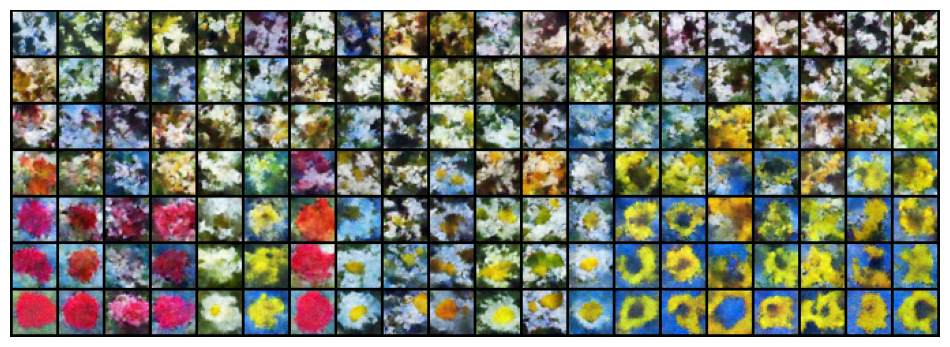

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

grid = make_grid(generated_images, nrow=len(text_prompts), normalize=True, scale_each=True)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.show()

## Metrics

### CLIP Score

In [10]:
import torch

import open_clip

from PIL import Image

def calculate_clip_score(image_path, text_prompt):

    # Load model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

    # Preprocess inputs
    image = preprocess(Image.open(image_path)).unsqueeze(0)
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer([text_prompt])

    # Compute features and similarity
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate dot product
        score = (image_features @ text_features.T).item()

    return score


### Fréchet Inception Distance (FID) 
FID measures the distance between the feature distributions of real images and generated images. Lower scores indicate that the generated images possess visual quality and diversity similar to the real dataset. Note that this metric is defined through the InceptionV3 model and you have to use an ImageNet pre-trained InceptionV3 model to compute it. Here's a demo notebook to do this.

In [11]:

import numpy as np

from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, gen_embeddings):

    # real_embeddings and gen_embeddings should be Numpy arrays of shape (N, 2048) 
    # extracted from an InceptionV3 model

    # Calculate mean and covariance
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical errors
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

## Part 2: Evaluation with CLIP Score and Frechet Inception Distance
Now, evaluate the quality of your generated images using the measures described in the Metrics Calculation Guide section.

In [12]:
import open_clip

# You can use the `calculate_clip_score` function from the evaluation guide.
for prompt, image_path in zip(text_prompts, image_paths):
    
    # Assuming you have saved generated images to disk, replace 'generated_image_path' with actual paths
    score = calculate_clip_score(image_path, prompt)
    print(f'CLIP score for prompt "{prompt}": {score}')

CLIP score for prompt "A photo of a red rose": 0.24750123918056488
CLIP score for prompt "A realistic photo of a rose": 0.2707371115684509
CLIP score for prompt "A picture of a rose with green leaves": 0.23237061500549316
CLIP score for prompt "A photo of a rose in bloom": 0.2511191666126251
CLIP score for prompt "A white rose with morning dew": 0.28625214099884033
CLIP score for prompt "A yellow rose in a garden": 0.21333752572536469
CLIP score for prompt "A close-up of a red rose": 0.21519559621810913
CLIP score for prompt "A photo of a white daisy": 0.3028961420059204
CLIP score for prompt "A field of daisies in sunlight": 0.22779132425785065
CLIP score for prompt "A close-up photo of a daisy": 0.22999583184719086
CLIP score for prompt "A white daisy with yellow center": 0.3136569857597351
CLIP score for prompt "A photo of daisies in a meadow": 0.2363760769367218
CLIP score for prompt "A single daisy flower": 0.20323240756988525
CLIP score for prompt "A photo of a yellow sunflower":

In [13]:
import torch.nn as nn
from torchvision.models import inception_v3, Inception_V3_Weights

inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
inception.fc = nn.Identity()  # Replace classifier with passthrough
inception.to(device)
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
import torchvision.transforms.v2 as transforms

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [17]:
import random

real_roses_paths = [os.path.join('data/cropped_flowers/roses', filename) for filename in os.listdir('data/cropped_flowers/roses')]
real_daisis_paths = [os.path.join('data/cropped_flowers/daisy', filename) for filename in os.listdir('data/cropped_flowers/daisy')]
real_sunflower_paths = [os.path.join('data/cropped_flowers/sunflowers', filename) for filename in os.listdir('data/cropped_flowers/sunflowers')]

real_img_paths = real_roses_paths + real_daisis_paths + real_sunflower_paths

random.seed(42)
random.shuffle(real_img_paths)

real_img_paths = real_img_paths[:len(text_prompts)]

real_embeddings = []
for path in real_img_paths:
    image = Image.open(path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = inception(image).squeeze().cpu().numpy()
    real_embeddings.append(embedding)

generated_embeddings = []
for path in image_paths:
    image = Image.open(path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = inception(image).squeeze().cpu().numpy()
    generated_embeddings.append(embedding)

In [18]:
fid_score = calculate_fid(np.array(real_embeddings), np.array(generated_embeddings))
print(f'FID score: {fid_score}')

FID score: 374.2612459759583


## Part 3: Embedding Analysis with FiftyOne Brain
In this section, you will use FiftyOne to analyze the embeddings you extracted from the U-Net.


In [19]:
import fiftyone as fo
import fiftyone.brain as fob

dataset_name = "generated_flowers_with_embeddings"
if(fo.dataset_exists(dataset_name)):
    fo.delete_dataset(dataset_name)
dataset = fo.Dataset(name="generated_flowers_with_embeddings")

for i, image_path in enumerate(image_paths):
    sample = fo.Sample(
        filepath=image_path,
        prompt=fo.Classification(label=text_prompts[i]),
        clip_score=float(calculate_clip_score(image_path, text_prompts[i])),
        unet_embedding=extracted_embeddings[i].flatten().cpu().numpy()
    )
    dataset.add_sample(sample)


In [21]:
fob.compute_uniqueness(dataset)

fob.compute_representativeness(dataset, embeddings="unet_embedding")

session = fo.launch_app(dataset)

Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |███████████████████| 20/20 [665.8ms elapsed, 0s remaining, 30.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 20/20 [665.8ms elapsed, 0s remaining, 30.0 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 20 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 20 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


In [28]:
dataset.first()

<Sample: {
    'id': '69700f2b09eb5b7924bb12d0',
    'media_type': 'image',
    'filepath': '/home/linus/HPI/applied-hands-on-computer-vision/assignment3/generated_images/generated_image_0.png',
    'tags': [],
    'metadata': None,
    'created_at': datetime.datetime(2026, 1, 20, 23, 26, 35, 196000),
    'last_modified_at': datetime.datetime(2026, 1, 20, 23, 28, 19, 970000),
    'prompt': <Classification: {
        'id': '69700f1c09eb5b7924bb12cf',
        'tags': [],
        'label': 'A photo of a red rose',
        'confidence': None,
        'logits': None,
    }>,
    'clip_score': 0.24750123918056488,
    'unet_embedding': array([ 0.7293367 ,  1.1042521 ,  0.6746698 , ..., -0.12135089,
           -0.02623937, -0.15579294], dtype=float32),
    'uniqueness': 0.2049235778899735,
    'representativeness': 1.0,
}>

## Part 4: Logging with Weights & Biases

In [ ]:
import wandb

wandb.login()

config = {
    "image_size": IMG_SIZE,
    "image_channels": IMG_CH,
    "num_steps": T
    
}

run = wandb.init(project="diffusion_model_assessment_v2", config=config)

clip_scores = [sample.clip_score for sample in dataset]
avg_clip_score = sum(clip_scores) / len(clip_scores)
run.log({
    "avg_clip_score": avg_clip_score,
    "fid_score": fid_score
})

table = wandb.Table(columns=["image", "prompt", "clip_score", "uniqueness", "representativeness"])
for sample in dataset:
    run.log({"clip_score": sample.clip_score})
    
    img = wandb.Image(Image.open(sample.filepath))
    prompt = sample.prompt.label
    clip_score = sample.clip_score
    uniqueness = sample.uniqueness
    representativeness = sample.representativeness
    
    table.add_data(img, prompt, clip_score, uniqueness, representativeness)

run.log({"generation_results": table})
run.finish()

avg_clip_score,▁
clip_score,▄▆▃▄▆▂▂▇▃▃█▄▂▅▄▁▃▅▃▅
fid_score,▁
avg_clip_score,0.24504
clip_score,0.26028
fid_score,374.26125


: 

In [30]:
from fiftyone.utils.huggingface import push_to_hub

push_to_hub(dataset, "diffusion_model_assessment_v2")

Directory '/tmp/tmppxdpq1hx' already exists; export will be merged with existing files


Exporting samples...


INFO:fiftyone.utils.data.exporters:Exporting samples...


 100% |██████████████████████| 20/20 [47.1ms elapsed, 0s remaining, 424.7 docs/s] 


INFO:eta.core.utils: 100% |██████████████████████| 20/20 [47.1ms elapsed, 0s remaining, 424.7 docs/s] 
Uploading media files: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
